### Case Study - Fig 5B

In [1]:
import pickle
import pandas as pd
from data_prepare import *
from functools import reduce

In [4]:
with open("./CombinationSplit/results.pickle", "rb") as f:
    results = pickle.load(f)
res = {}
models = results.keys()
for model in models:
    train_combs = results[model]['train_combs']
    test_combs = reduce(lambda x,y: x+y, [results[model]["cat_test_combs"],
                                          results[model]["subs_test_combs"],
                                          results[model]["catsubs_test_combs"]])
    catalysts = list(set([x.split("_")[0] + "_" + x.split("_")[1] for x in test_combs]))
    train_catalysts = list(set([x.split("_")[0] + "_" + x.split("_")[1] for x in train_combs]))
    test_catalysts = [cat for cat in catalysts if cat not in train_catalysts]

    reactions = pd.Series(train_combs + test_combs)
    observed_data = pd.Series(np.concatenate((results[model]["train_observed_ddG"],
                                              results[model]["cat_observed_ddG"],
                                              results[model]["subs_observed_ddG"],
                                              results[model]["catsubs_observed_ddG"])), index=reactions)
    predict_data = pd.Series(np.concatenate((results[model]["train_predict_ddG"],
                                             results[model]["cat_predict_ddG"],
                                             results[model]["subs_predict_ddG"],
                                             results[model]["catsubs_predict_ddG"])), index=reactions)
    observed_ddGs = dict([(cat, observed_data[reactions[reactions.apply(lambda x: cat in x)]].mean()) for cat in test_catalysts])
    predict_ddGs = dict([(cat, predict_data[reactions[reactions.apply(lambda x: cat in x)]].mean()) for cat in test_catalysts])

    df = pd.DataFrame({"Observed": observed_ddGs, "Predicted": predict_ddGs})
    df = df.sort_values(by="Observed",ascending=False)
    res[model] = df
res

{'RF':         Observed  Predicted
 166_i   2.395882   2.346121
 147_i   2.193830   2.187127
 87_i    1.590295   1.595226
 145_i   1.524832   1.550835
 7_i     1.331835   1.331566
 382_i   1.101050   1.106613
 5_i     1.043506   1.052592
 229_i   1.018286   1.018348
 229_vi  1.010018   1.011063
 371_i   0.992345   0.992354
 61_i    0.991006   0.991028
 73_i    0.962070   0.961687
 29_i    0.954099   0.953294
 1_i     0.946596   0.946482
 365_vi  0.944685   0.943268
 223_i   0.623830   0.624153
 242_vi  0.227116   0.225910
 210_i   0.120919   0.119901
 245_i   0.119578   0.116565,
 'LASSO':         Observed  Predicted
 166_i   2.395882   2.337901
 147_i   2.193830   2.094423
 87_i    1.590295   1.463728
 145_i   1.524832   1.375825
 7_i     1.331835   1.257711
 382_i   1.101050   1.027692
 5_i     1.043506   1.012046
 229_i   1.018286   1.018974
 229_vi  1.010018   1.011304
 371_i   0.992345   0.917969
 61_i    0.991006   0.922934
 73_i    0.962070   0.896848
 29_i    0.954099   0.93196

### Case Study - Fig S10

In [5]:
import pickle
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math

with open("./CombinationSplit/results.pickle", "rb") as f:
    datas = pickle.load(f)

In [6]:
def MAD(y, y_hat):
    return abs(y_hat - y).mean()

def R_square(y, y_hat):
    y_bar = y.mean()
    SSE = ((y - y_hat) ** 2).sum()
    SST = ((y - y_bar) ** 2).sum()
    return 1 - SSE / SST

,R^2,MAD_train,MAD_cat,MAD_subs,MAD_catsubs
RF,0.995823,0.005434,0.018393,0.018586,0.026756
LASSO,0.964129,0.071287,0.078073,0.166035,0.138277
RIDGE,0.974535,0.048749,0.062560,0.129309,0.119049
LASSOLARS,0.972771,0.062320,0.066581,0.132167,0.084142
SVR_POLY2,0.445781,0.169315,0.392541,0.510926,0.594406
SVR_RBF,0.983856,0.016033,0.044320,0.094264,0.092298
SVR_LINEAR,0.966303,0.062273,0.064570,0.101709,0.105018
EN,0.969324,0.050651,0.063751,0.150875,0.135447
KR_RBF,0.729255,0.089690,0.182465,0.469076,0.440861
KR_LINEAR,-2.285870,0.048724,1.253995,1.110044,1.641224


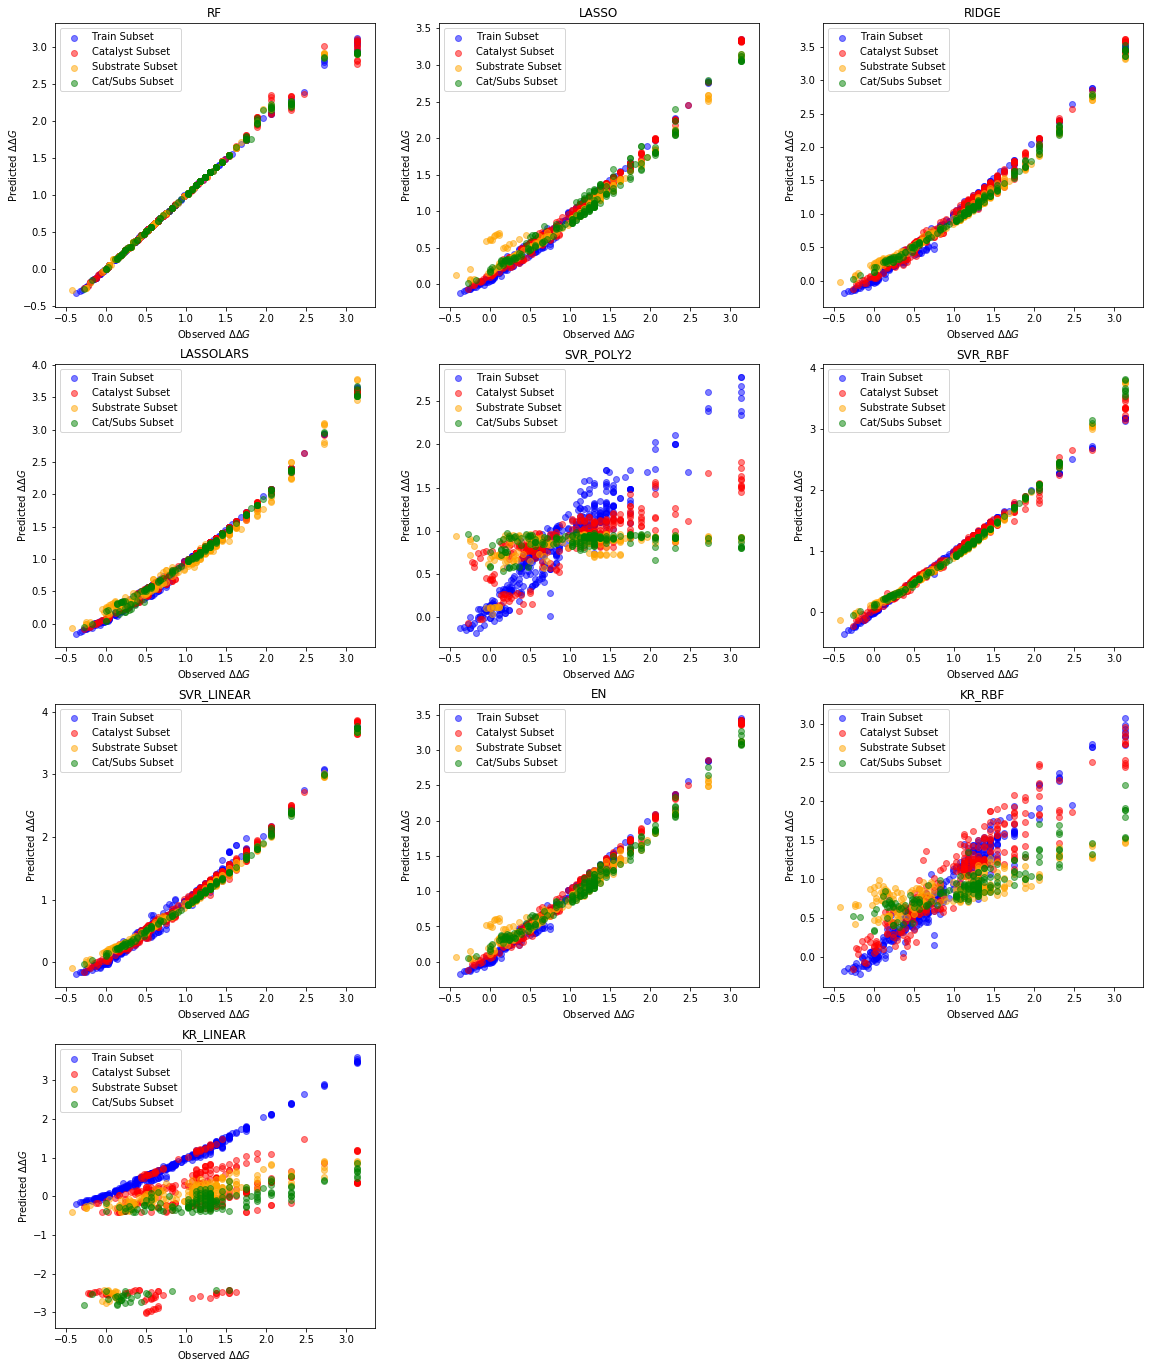

In [7]:
models = list(datas.keys())
fig = plt.figure(figsize=(19.5, math.ceil(len(models)/3) * 6))
gs = fig.add_gridspec(math.ceil(len(models)/3), 3)
results = {}
for k in range(len(models)):
    model = models[k]
    data = datas[model]
    observed_train, predict_train = data['train_observed_ddG'], data['train_predict_ddG']
    MAD_train = MAD(observed_train, predict_train)

    observed_cat, predict_cat = data['cat_observed_ddG'], data['cat_predict_ddG']
    MAD_cat = MAD(observed_cat, predict_cat)

    observed_subs, predict_subs = data['subs_observed_ddG'], data['subs_predict_ddG']
    MAD_subs = MAD(observed_subs, predict_subs)

    observed_catsubs, predict_catsubs = data['catsubs_observed_ddG'], data['catsubs_predict_ddG']
    MAD_catsubs = MAD(observed_catsubs, predict_catsubs)
    
    i, j = divmod(k, 3)
    ax = fig.add_subplot(gs[i, j])
    ax.scatter(observed_train, predict_train, color="blue", alpha=0.5, marker='o', label='Train Subset')
    ax.scatter(observed_cat, predict_cat, color="red", alpha=0.5, marker='o', label="Catalyst Subset")
    ax.scatter(observed_subs, predict_subs, color="orange", alpha=0.5, marker='o', label="Substrate Subset")
    ax.scatter(observed_catsubs, predict_catsubs, color="green", alpha=0.5, marker='o', label="Cat/Subs Subset")
    ax.legend()
    ax.set_title(model)
    ax.set_xlabel("Observed $\Delta\Delta G$")
    ax.set_ylabel("Predicted $\Delta\Delta G$")
    
    observed_total = np.concatenate((observed_train, observed_cat, observed_subs, observed_catsubs))
    predict_total = np.concatenate((predict_train, predict_cat, predict_subs, predict_catsubs))
    R_2 = R_square(observed_total, predict_total)
    results[model] = {"R^2": R_2, "MAD_train": MAD_train, "MAD_cat": MAD_cat, "MAD_subs": MAD_subs, "MAD_catsubs": MAD_catsubs}

res = pd.DataFrame(results).T
res